# TODO:

- store output of state vars in xarray-simlab data structure
    1. for gekko solver
    2. for odeint solver
    3. for step-wise solver
    
this needs to be completely wrapped in the backend..
i need to somehow combine the "core.parts" so that they are automatically initialized with the xs.Model

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import xsimlab as xs

# to measure process time
import time as tm

In [2]:
from xsimlab.monitoring import ProgressBar

In [3]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [4]:
from phydra.processes.main import ModelCore, Solver

from phydra.processes.statevars import SV, Time

from phydra.processes.fluxes import Flux, ForcingFlux

In [5]:
Model = phydra.create({
    # SV
    'y':SV,
    'x':SV, 
    
    # Fluxes
    'y_loss':Flux,
    'x_loss':Flux,
    
    # Forcing
    #'y_input':ForcingFlux
})

In [6]:
Model

<xsimlab.Model (7 processes, 8 inputs)>
Core
    solver_type     [in]
Time
    time            [in] ('TIME',) A sequence of Time points for wh...
y
    init            [in]
x
    init            [in]
y_loss
    k               [in]
    sv_label        [in]
x_loss
    k               [in]
    sv_label        [in]
Solver

In [7]:
odeint_setup = phydra.setup('odeint', Model,
            time=np.arange(0,20,0.01),
            input_vars={
                'y__init':0.5,
                'x__init':0.5,
                
                'y_loss__sv_label':'y',
                'y_loss__k':0.5,
                
                'x_loss__sv_label':'x',
                'x_loss__k':0.01
            },
            output_vars={
                'y__value':None,
                'x__value':None,
            })

In [8]:
gekko_setup = phydra.setup('gekko', Model,
            time=np.arange(0,20,0.01),
            input_vars={
                'y__init':0.5,
                'x__init':0.5,
                
                'y_loss__sv_label':'y',
                'y_loss__k':0.5,
                
                'x_loss__sv_label':'x',
                'x_loss__k':0.01
            },
            output_vars={
                'y__value':None,
                'x__value':None,
            })

In [9]:
stepwise_setup = phydra.setup('stepwise', Model,       
            time=np.arange(0,20,0.01),
            input_vars={
                'y__init':0.5,
                'x__init':0.5,
                
                'y_loss__sv_label':'y',
                'y_loss__k':0.5,
                
                'x_loss__sv_label':'x',
                'x_loss__k':0.01
            },
            output_vars={
                'y__value':None,
                'x__value':None,
            })

In [10]:
stepwise_setup


<xarray.Dataset>
Dimensions:            (TIME: 1, Time: 2000)
Coordinates:
  * Time               (Time) float64 0.0 0.01 0.02 0.03 ... 19.97 19.98 19.99
Dimensions without coordinates: TIME
Data variables:
    y__init            float64 0.5
    x__init            float64 0.5
    y_loss__sv_label   <U1 'y'
    y_loss__k          float64 0.5
    x_loss__sv_label   <U1 'x'
    x_loss__k          float64 0.01
    Core__solver_type  <U8 'stepwise'
    Time__time         (TIME) int64 0
Attributes:
    __xsimlab_output_vars__:  y__value,x__value

In [11]:
with ProgressBar(frontend="console"):
        out_ds = odeint_setup.xsimlab.run(model=Model)

██████████ 100% | Simulation finished in 00:00 

initializing model core
Initializing Model Time
initializing state variable y
initializing state variable x
initializing state variable y_loss
initializing state variable x_loss
assembling model
SOLVER : odeint
start solve now
Model was solved in 0.00157 seconds
here unpacking values time
here unpacking values y
here unpacking values x
finalizing: cleanup


In [12]:
out_ds

<xarray.Dataset>
Dimensions:            (TIME: 2000, clock: 2, time: 2000)
Coordinates:
  * clock              (clock) int64 0 1
Dimensions without coordinates: TIME, time
Data variables:
    Core__solver_type  <U6 'odeint'
    Time__time         (TIME) float64 0.0 0.01 0.02 0.03 ... 19.97 19.98 19.99
    x__init            float64 0.5
    x__value           (time) float64 0.5 0.5 0.4999 ... 0.4095 0.4094 0.4094
    x_loss__k          float64 0.01
    x_loss__sv_label   <U1 'x'
    y__init            float64 0.5
    y__value           (time) float64 0.5 0.4975 0.495 ... 2.293e-05 2.281e-05
    y_loss__k          float64 0.5
    y_loss__sv_label   <U1 'y'

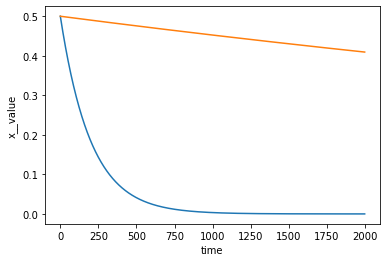

In [13]:
out_ds.y__value.plot()
out_ds.x__value.plot()

In [14]:
with ProgressBar(frontend="console"):
        out_ds1 = gekko_setup.xsimlab.run(model=Model)

███▎        33% | initialize 

initializing model core
Initializing Model Time
initializing state variable y
initializing state variable x
initializing state variable y_loss
initializing state variable x_loss
assembling model
SOLVER : gekko
VALS [0.0, 0.5, 0.5]
{'_remote': True, '_server': 'http://byu.apmonitor.com', 'options': <gekko.gk_global_options.GKGlobalOptions object at 0x15e58c0d0>, '_id': 0, '_gui_open': False, '_constants': [], '_parameters': [], '_variables': [0.0, 0.5, 0.5], '_intermediates': [], '_inter_equations': [], '_equations': [], '_objectives': [], '_connections': [], '_objects': [], '_compounds': [], '_raw': [], 'time': None, '_model_initialized': False, '_csv_status': None, '_model': '', '_model_name': 'gk_model0', '_path': '/var/folders/s8/8ypwvww534g_q5s51__36bmc0000gp/T/tmp6ke4efhxgk_model0', 'path': '/var/folders/s8/8ypwvww534g_q5s51__36bmc0000gp/T/tmp6ke4efhxgk_model0', '_extra_files': [], 'solver_options': []}


Exception:  @error: Insufficient Data
 CSV Read Error  : number of data rows must be >= 2 for dynamic problems
 Data Points Identified:           1
 STOPPING. . .


In [ ]:
out_ds1

In [15]:
out_ds1.y__value.plot()
out_ds1.x__value.plot()

NameError: name 'out_ds1' is not defined

In [18]:
with ProgressBar(frontend="console"):
        out_ds2 = stepwise_setup.xsimlab.run(model=Model)



             0% | initialize 

             0% | run step 0/1999 

             0% | run step 1/1999 

             0% | run step 2/1999 

             0% | run step 3/1999 

             0% | run step 4/1999 

             0% | run step 5/1999 

             0% | run step 6/1999 

             0% | run step 7/1999 

             0% | run step 8/1999 

             0% | run step 9/1999 

             1% | run step 10/1999 

             1% | run step 11/1999 

             1% | run step 12/1999 

             1% | run step 13/1999 

             1% | run step 14/1999 

             1% | run step 15/1999 

             1% | run step 16/1999 

             1% | run step 17/1999 

             1% | run step 18/1999 

             1% | run step 19/1999 

             1% | run step 20/1999 

             1% | run step 21/1999 

             1% | run step 22/1999 

             1% | run step 23/1999 

             1% | run step 24/1999 

▏            1% | run step 25/1999 

▏            1%

initializing model core
Initializing Model Time
initializing state variable y
initializing state variable x
initializing state variable y_loss
initializing state variable x_loss
assembling model
SOLVER : stepwise


▍            4% | run step 77/1999 

▍            4% | run step 77/1999 

▍            4% | run step 78/1999 

▍            4% | run step 79/1999 

▍            4% | run step 80/1999 

▍            4% | run step 81/1999 

▍            4% | run step 82/1999 

▍            4% | run step 83/1999 

▍            4% | run step 84/1999 

▍            4% | run step 85/1999 

▍            4% | run step 86/1999 

▍            4% | run step 87/1999 

▍            4% | run step 88/1999 

▍            4% | run step 89/1999 

▍            5% | run step 90/1999 

▍            5% | run step 91/1999 

▍            5% | run step 92/1999 

▍            5% | run step 93/1999 

▍            5% | run step 94/1999 

▍            5% | run step 95/1999 

▍            5% | run step 96/1999 

▍            5% | run step 97/1999 

▍            5% | run step 98/1999 

▍            5% | run step 99/1999 

▌            5% | run step 100/1999 

▌            5% | run step 101/1999 

▌            5% | run step 102/1999 

finalizing: cleanup


In [19]:
out_ds2

<xarray.Dataset>
Dimensions:            (TIME: 1, Time: 2000, time: 2000)
Coordinates:
  * Time               (Time) float64 0.0 0.01 0.02 0.03 ... 19.97 19.98 19.99
Dimensions without coordinates: TIME, time
Data variables:
    Core__solver_type  <U8 'stepwise'
    Time__time         (TIME) int64 0
    x__init            float64 0.5
    x__value           (time) float64 0.5 0.5 0.4999 ... 0.4095 0.4094 0.4094
    x_loss__k          float64 0.01
    x_loss__sv_label   <U1 'x'
    y__init            float64 0.5
    y__value           (time) float64 0.5 0.4975 0.495 ... 2.236e-05 2.225e-05
    y_loss__k          float64 0.5
    y_loss__sv_label   <U1 'y'

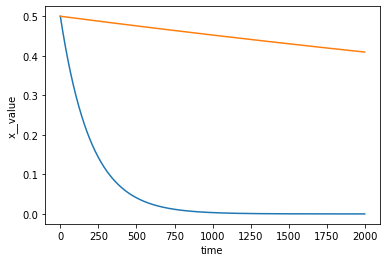

In [20]:
out_ds2.y__value.plot()
out_ds2.x__value.plot()